In [70]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, auc

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
#data
df_all = pd.read_excel('/home/chiluen/Desktop/Fintech_NanShan/data/repurchase_data.xlsx', sheet_name=0)
df_personal = pd.read_excel('/home/chiluen/Desktop/Fintech_NanShan/data/repurchase_data.xlsx', sheet_name=1)
df_behavior = pd.read_excel('/home/chiluen/Desktop/Fintech_NanShan/data/repurchase_data.xlsx', sheet_name=2)

ans_all = np.array((df_all['REPURCHASE']))
ans_personal = np.array((df_personal['REPURCHASE']))
ans_behavior = np.array((df_behavior['REPURCHASE']))

### Personal + Behavior

In [4]:
#df = pd.read_excel('personal_and_behavioral.xlsx')
#ans = np.array((df['REPURCHASE']))
df = df_all.copy()
ans = ans_all.copy()

In [5]:
#做k-fold資料準備
cv = KFold(n_splits=5)
train_index_list = []
test_index_list = []
for train_index, test_index in cv.split(df):
    train_index_list.append(list(train_index))
    test_index_list.append(list(test_index))

In [153]:
def bootstrap(train_majority, train_minority, seed, multiply = 1):
    n_samples = 4000
    train_majority_downsample = resample(train_majority, replace=False,n_samples=int(n_samples*multiply),random_state=seed)
    train_minority_downsample = resample(train_minority, replace=False,n_samples=n_samples,random_state=seed)
    train_downsample = pd.concat([train_majority_downsample, train_minority_downsample])
    ans = np.array(train_downsample['REPURCHASE'])
    train_downsample = train_downsample.drop(['REPURCHASE'], axis=1)
    return np.array(train_downsample), ans

class build_dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = torch.LongTensor(y)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)
    
class model(nn.Module):
    def __init__(self, dimension):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(dimension, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            
            nn.Linear(20,10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            
            nn.Linear(10,2),
            nn.Softmax()
        )
        
    def forward(self, x):
        output = self.fc(x)
        return output

In [154]:
model_predict_all_data = []
multiplier_list = [1, 1.5, 2]
for multiplier in multiplier_list:
    print("The " + str(multiplier) + " multiplier")
    for n_fold in range(5):

        #5-fold
        X_train = df.loc[train_index_list[n_fold]]
        X_test = df.loc[test_index_list[n_fold]]
        y_train = ans[train_index_list[n_fold]]
        y_test = ans[test_index_list[n_fold]]

        train_majority = X_train[X_train.REPURCHASE==0] 
        train_minority = X_train[X_train.REPURCHASE==1] 

        #建立dataloader

        valid_dataset = build_dataset(np.array(X_test.drop(['REPURCHASE'], axis=1)), y_test)
        valid_dataloader = DataLoader(
            dataset = valid_dataset,
            batch_size = 100,
            shuffle = False,
            num_workers = 2
        )

        seed = [0,1,2,3,4]
        dataloader_list = []
        for i in seed:
            data_train, label_train = bootstrap(train_majority, train_minority, i, multiply = multiplier)
            repurchase_dataset = build_dataset(data_train, label_train)
            repurchase_dataloader = DataLoader(
            dataset = repurchase_dataset,
            batch_size = 100,
            shuffle = True,
            num_workers = 2
            )
            dataloader_list.append(repurchase_dataloader)
        print('finish data preprocessing for %01d - fold' %(n_fold+1))


        # training
        total_train_loss = []
        total_valid_loss = []
        number_of_bootstrap = 0

        # model setting
        dimension = data_train.shape[1]
        classifier = model(dimension).cuda()

        # parameters
        lr = 0.01
        num_epochs = 10
        CrossEntropy = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(classifier.parameters(), lr = lr)

        for repurchase_dataloader in dataloader_list:
            number_of_bootstrap += 1
            for epoch in range(num_epochs):

                train_acc = 0
                train_loss = 0
                valid_acc = 0
                valid_loss = 0
                train_counter = 0
                valid_counter = 0

                classifier.train()
                for i, data in enumerate(repurchase_dataloader):

                    optim.zero_grad()
                    pred = classifier(data[0].float().cuda())
                    loss = CrossEntropy(pred, data[1].cuda())
                    loss.backward()
                    optim.step()

                    total_train_loss.append(loss.item())
                    train_acc += np.sum(np.argmax(pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                    train_loss += loss.item()


                #evaluation on valid set
                classifier.eval()
                with torch.no_grad():
                    for i, data in enumerate(valid_dataloader):
                        pred = classifier(data[0].float().cuda())
                        loss = CrossEntropy(pred, data[1].cuda())

                        total_valid_loss.append(loss.item())
                        valid_acc += np.sum(np.argmax(pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                        valid_loss += loss.item()

                print("Bootstrap: %02d | Epoch: %02d | train_acc: %6.6f train_loss: %6.6f | valid_acc: %6.6f valid_loss: %6.6f" % \
                      (number_of_bootstrap, epoch+1, train_acc/repurchase_dataset.__len__(), train_loss/repurchase_dataset.__len__(), \
                       valid_acc/valid_dataset.__len__(), valid_loss/valid_dataset.__len__()))

        X_test_tensor = torch.tensor(np.array(X_test.drop(['REPURCHASE'], axis=1))).float().cuda()
        model_predict = classifier(X_test_tensor)  
        model_predict_all_data.append(model_predict.cpu().data.numpy())


The 1 multiplier
finish data preprocessing for 1 - fold
Bootstrap: 01 | Epoch: 01 | train_acc: 0.703125 train_loss: 0.005915 | valid_acc: 0.692517 valid_loss: 0.006057
Bootstrap: 01 | Epoch: 02 | train_acc: 0.718625 train_loss: 0.005767 | valid_acc: 0.742961 valid_loss: 0.005652
Bootstrap: 01 | Epoch: 03 | train_acc: 0.721625 train_loss: 0.005757 | valid_acc: 0.671071 valid_loss: 0.006067
Bootstrap: 01 | Epoch: 04 | train_acc: 0.716750 train_loss: 0.005741 | valid_acc: 0.708458 valid_loss: 0.005864
Bootstrap: 01 | Epoch: 05 | train_acc: 0.724750 train_loss: 0.005712 | valid_acc: 0.677364 valid_loss: 0.006063
Bootstrap: 01 | Epoch: 06 | train_acc: 0.723375 train_loss: 0.005707 | valid_acc: 0.741020 valid_loss: 0.005588
Bootstrap: 01 | Epoch: 07 | train_acc: 0.724125 train_loss: 0.005707 | valid_acc: 0.720046 valid_loss: 0.005784
Bootstrap: 01 | Epoch: 08 | train_acc: 0.730750 train_loss: 0.005657 | valid_acc: 0.725080 valid_loss: 0.005737
Bootstrap: 01 | Epoch: 09 | train_acc: 0.730250 

Bootstrap: 03 | Epoch: 04 | train_acc: 0.728125 train_loss: 0.005651 | valid_acc: 0.721986 valid_loss: 0.005680
Bootstrap: 03 | Epoch: 05 | train_acc: 0.732750 train_loss: 0.005619 | valid_acc: 0.661161 valid_loss: 0.006088
Bootstrap: 03 | Epoch: 06 | train_acc: 0.734500 train_loss: 0.005624 | valid_acc: 0.701064 valid_loss: 0.005830
Bootstrap: 03 | Epoch: 07 | train_acc: 0.736250 train_loss: 0.005610 | valid_acc: 0.722248 valid_loss: 0.005642
Bootstrap: 03 | Epoch: 08 | train_acc: 0.736750 train_loss: 0.005596 | valid_acc: 0.689633 valid_loss: 0.005834
Bootstrap: 03 | Epoch: 09 | train_acc: 0.739250 train_loss: 0.005573 | valid_acc: 0.661633 valid_loss: 0.006144
Bootstrap: 03 | Epoch: 10 | train_acc: 0.740250 train_loss: 0.005584 | valid_acc: 0.702900 valid_loss: 0.005817
Bootstrap: 04 | Epoch: 01 | train_acc: 0.720125 train_loss: 0.005712 | valid_acc: 0.688637 valid_loss: 0.005937
Bootstrap: 04 | Epoch: 02 | train_acc: 0.730625 train_loss: 0.005655 | valid_acc: 0.693304 valid_loss: 0

Bootstrap: 05 | Epoch: 07 | train_acc: 0.745750 train_loss: 0.005506 | valid_acc: 0.167899 valid_loss: 0.008751
Bootstrap: 05 | Epoch: 08 | train_acc: 0.745125 train_loss: 0.005524 | valid_acc: 0.480363 valid_loss: 0.007533
Bootstrap: 05 | Epoch: 09 | train_acc: 0.746750 train_loss: 0.005503 | valid_acc: 0.242410 valid_loss: 0.008757
Bootstrap: 05 | Epoch: 10 | train_acc: 0.748875 train_loss: 0.005499 | valid_acc: 0.202926 valid_loss: 0.008665
finish data preprocessing for 4 - fold
Bootstrap: 01 | Epoch: 01 | train_acc: 0.694250 train_loss: 0.005968 | valid_acc: 0.705574 valid_loss: 0.005960
Bootstrap: 01 | Epoch: 02 | train_acc: 0.711375 train_loss: 0.005786 | valid_acc: 0.705731 valid_loss: 0.005995
Bootstrap: 01 | Epoch: 03 | train_acc: 0.720250 train_loss: 0.005719 | valid_acc: 0.720833 valid_loss: 0.005869
Bootstrap: 01 | Epoch: 04 | train_acc: 0.723375 train_loss: 0.005738 | valid_acc: 0.727807 valid_loss: 0.005831
Bootstrap: 01 | Epoch: 05 | train_acc: 0.722875 train_loss: 0.005

Bootstrap: 02 | Epoch: 10 | train_acc: 0.735125 train_loss: 0.005596 | valid_acc: 0.751665 valid_loss: 0.005458
Bootstrap: 03 | Epoch: 01 | train_acc: 0.713375 train_loss: 0.005816 | valid_acc: 0.689738 valid_loss: 0.006070
Bootstrap: 03 | Epoch: 02 | train_acc: 0.717000 train_loss: 0.005773 | valid_acc: 0.726915 valid_loss: 0.005623
Bootstrap: 03 | Epoch: 03 | train_acc: 0.719750 train_loss: 0.005747 | valid_acc: 0.719207 valid_loss: 0.005741
Bootstrap: 03 | Epoch: 04 | train_acc: 0.721875 train_loss: 0.005730 | valid_acc: 0.669393 valid_loss: 0.006141
Bootstrap: 03 | Epoch: 05 | train_acc: 0.723625 train_loss: 0.005716 | valid_acc: 0.693356 valid_loss: 0.005904
Bootstrap: 03 | Epoch: 06 | train_acc: 0.723875 train_loss: 0.005702 | valid_acc: 0.727387 valid_loss: 0.005726
Bootstrap: 03 | Epoch: 07 | train_acc: 0.731125 train_loss: 0.005681 | valid_acc: 0.736091 valid_loss: 0.005576
Bootstrap: 03 | Epoch: 08 | train_acc: 0.729250 train_loss: 0.005656 | valid_acc: 0.649468 valid_loss: 0

Bootstrap: 05 | Epoch: 03 | train_acc: 0.740800 train_loss: 0.005528 | valid_acc: 0.798175 valid_loss: 0.005079
Bootstrap: 05 | Epoch: 04 | train_acc: 0.745200 train_loss: 0.005503 | valid_acc: 0.815794 valid_loss: 0.004989
Bootstrap: 05 | Epoch: 05 | train_acc: 0.745400 train_loss: 0.005465 | valid_acc: 0.820093 valid_loss: 0.004899
Bootstrap: 05 | Epoch: 06 | train_acc: 0.746700 train_loss: 0.005487 | valid_acc: 0.797441 valid_loss: 0.005098
Bootstrap: 05 | Epoch: 07 | train_acc: 0.753100 train_loss: 0.005455 | valid_acc: 0.797965 valid_loss: 0.005095
Bootstrap: 05 | Epoch: 08 | train_acc: 0.752000 train_loss: 0.005465 | valid_acc: 0.796707 valid_loss: 0.005061
Bootstrap: 05 | Epoch: 09 | train_acc: 0.749400 train_loss: 0.005455 | valid_acc: 0.791883 valid_loss: 0.005104
Bootstrap: 05 | Epoch: 10 | train_acc: 0.750900 train_loss: 0.005439 | valid_acc: 0.797179 valid_loss: 0.005049
finish data preprocessing for 2 - fold
Bootstrap: 01 | Epoch: 01 | train_acc: 0.727700 train_loss: 0.005

Bootstrap: 02 | Epoch: 06 | train_acc: 0.746300 train_loss: 0.005525 | valid_acc: 0.763148 valid_loss: 0.005305
Bootstrap: 02 | Epoch: 07 | train_acc: 0.747400 train_loss: 0.005509 | valid_acc: 0.752451 valid_loss: 0.005386
Bootstrap: 02 | Epoch: 08 | train_acc: 0.750900 train_loss: 0.005508 | valid_acc: 0.773163 valid_loss: 0.005256
Bootstrap: 02 | Epoch: 09 | train_acc: 0.747600 train_loss: 0.005504 | valid_acc: 0.800745 valid_loss: 0.005072
Bootstrap: 02 | Epoch: 10 | train_acc: 0.753100 train_loss: 0.005479 | valid_acc: 0.763620 valid_loss: 0.005331
Bootstrap: 03 | Epoch: 01 | train_acc: 0.730000 train_loss: 0.005632 | valid_acc: 0.778040 valid_loss: 0.005318
Bootstrap: 03 | Epoch: 02 | train_acc: 0.734300 train_loss: 0.005594 | valid_acc: 0.787321 valid_loss: 0.005241
Bootstrap: 03 | Epoch: 03 | train_acc: 0.740100 train_loss: 0.005572 | valid_acc: 0.799539 valid_loss: 0.005226
Bootstrap: 03 | Epoch: 04 | train_acc: 0.741600 train_loss: 0.005558 | valid_acc: 0.773111 valid_loss: 0

Bootstrap: 04 | Epoch: 09 | train_acc: 0.752600 train_loss: 0.005460 | valid_acc: 0.808086 valid_loss: 0.005117
Bootstrap: 04 | Epoch: 10 | train_acc: 0.752900 train_loss: 0.005462 | valid_acc: 0.787741 valid_loss: 0.005168
Bootstrap: 05 | Epoch: 01 | train_acc: 0.747800 train_loss: 0.005508 | valid_acc: 0.836401 valid_loss: 0.004869
Bootstrap: 05 | Epoch: 02 | train_acc: 0.748000 train_loss: 0.005496 | valid_acc: 0.794767 valid_loss: 0.005089
Bootstrap: 05 | Epoch: 03 | train_acc: 0.751100 train_loss: 0.005479 | valid_acc: 0.811441 valid_loss: 0.005041
Bootstrap: 05 | Epoch: 04 | train_acc: 0.753300 train_loss: 0.005456 | valid_acc: 0.798700 valid_loss: 0.005078
Bootstrap: 05 | Epoch: 05 | train_acc: 0.753800 train_loss: 0.005454 | valid_acc: 0.806617 valid_loss: 0.005052
Bootstrap: 05 | Epoch: 06 | train_acc: 0.757400 train_loss: 0.005428 | valid_acc: 0.796235 valid_loss: 0.005102
Bootstrap: 05 | Epoch: 07 | train_acc: 0.756100 train_loss: 0.005417 | valid_acc: 0.782707 valid_loss: 0

Bootstrap: 02 | Epoch: 02 | train_acc: 0.762333 train_loss: 0.005382 | valid_acc: 0.827592 valid_loss: 0.004836
Bootstrap: 02 | Epoch: 03 | train_acc: 0.765083 train_loss: 0.005356 | valid_acc: 0.840229 valid_loss: 0.004716
Bootstrap: 02 | Epoch: 04 | train_acc: 0.768833 train_loss: 0.005335 | valid_acc: 0.835876 valid_loss: 0.004749
Bootstrap: 02 | Epoch: 05 | train_acc: 0.768083 train_loss: 0.005329 | valid_acc: 0.836401 valid_loss: 0.004722
Bootstrap: 02 | Epoch: 06 | train_acc: 0.767917 train_loss: 0.005308 | valid_acc: 0.820303 valid_loss: 0.004893
Bootstrap: 02 | Epoch: 07 | train_acc: 0.770083 train_loss: 0.005307 | valid_acc: 0.829427 valid_loss: 0.004831
Bootstrap: 02 | Epoch: 08 | train_acc: 0.770417 train_loss: 0.005297 | valid_acc: 0.842641 valid_loss: 0.004738
Bootstrap: 02 | Epoch: 09 | train_acc: 0.772417 train_loss: 0.005288 | valid_acc: 0.833360 valid_loss: 0.004788
Bootstrap: 02 | Epoch: 10 | train_acc: 0.770583 train_loss: 0.005285 | valid_acc: 0.843952 valid_loss: 0

Bootstrap: 04 | Epoch: 05 | train_acc: 0.772250 train_loss: 0.005296 | valid_acc: 0.815846 valid_loss: 0.004914
Bootstrap: 04 | Epoch: 06 | train_acc: 0.771583 train_loss: 0.005291 | valid_acc: 0.850349 valid_loss: 0.004636
Bootstrap: 04 | Epoch: 07 | train_acc: 0.773333 train_loss: 0.005274 | valid_acc: 0.853180 valid_loss: 0.004618
Bootstrap: 04 | Epoch: 08 | train_acc: 0.774500 train_loss: 0.005273 | valid_acc: 0.835876 valid_loss: 0.004739
Bootstrap: 04 | Epoch: 09 | train_acc: 0.776333 train_loss: 0.005270 | valid_acc: 0.839023 valid_loss: 0.004720
Bootstrap: 04 | Epoch: 10 | train_acc: 0.777500 train_loss: 0.005251 | valid_acc: 0.834670 valid_loss: 0.004751
Bootstrap: 05 | Epoch: 01 | train_acc: 0.771000 train_loss: 0.005302 | valid_acc: 0.830056 valid_loss: 0.004807
Bootstrap: 05 | Epoch: 02 | train_acc: 0.773667 train_loss: 0.005266 | valid_acc: 0.838603 valid_loss: 0.004714
Bootstrap: 05 | Epoch: 03 | train_acc: 0.774250 train_loss: 0.005264 | valid_acc: 0.841435 valid_loss: 0

Bootstrap: 01 | Epoch: 08 | train_acc: 0.756000 train_loss: 0.005415 | valid_acc: 0.827067 valid_loss: 0.004853
Bootstrap: 01 | Epoch: 09 | train_acc: 0.758583 train_loss: 0.005404 | valid_acc: 0.831419 valid_loss: 0.004863
Bootstrap: 01 | Epoch: 10 | train_acc: 0.760500 train_loss: 0.005419 | valid_acc: 0.820775 valid_loss: 0.004858
Bootstrap: 02 | Epoch: 01 | train_acc: 0.757667 train_loss: 0.005425 | valid_acc: 0.832363 valid_loss: 0.004832
Bootstrap: 02 | Epoch: 02 | train_acc: 0.756167 train_loss: 0.005418 | valid_acc: 0.830266 valid_loss: 0.004794
Bootstrap: 02 | Epoch: 03 | train_acc: 0.758750 train_loss: 0.005390 | valid_acc: 0.818520 valid_loss: 0.004907
Bootstrap: 02 | Epoch: 04 | train_acc: 0.762000 train_loss: 0.005367 | valid_acc: 0.832468 valid_loss: 0.004844
Bootstrap: 02 | Epoch: 05 | train_acc: 0.762333 train_loss: 0.005377 | valid_acc: 0.824498 valid_loss: 0.004837
Bootstrap: 02 | Epoch: 06 | train_acc: 0.763583 train_loss: 0.005350 | valid_acc: 0.831891 valid_loss: 0

Bootstrap: 04 | Epoch: 01 | train_acc: 0.761333 train_loss: 0.005385 | valid_acc: 0.852499 valid_loss: 0.004587
Bootstrap: 04 | Epoch: 02 | train_acc: 0.768250 train_loss: 0.005342 | valid_acc: 0.855907 valid_loss: 0.004537
Bootstrap: 04 | Epoch: 03 | train_acc: 0.765833 train_loss: 0.005336 | valid_acc: 0.858843 valid_loss: 0.004506
Bootstrap: 04 | Epoch: 04 | train_acc: 0.766417 train_loss: 0.005326 | valid_acc: 0.861360 valid_loss: 0.004487
Bootstrap: 04 | Epoch: 05 | train_acc: 0.768667 train_loss: 0.005313 | valid_acc: 0.859944 valid_loss: 0.004513
Bootstrap: 04 | Epoch: 06 | train_acc: 0.770667 train_loss: 0.005299 | valid_acc: 0.848356 valid_loss: 0.004579
Bootstrap: 04 | Epoch: 07 | train_acc: 0.771167 train_loss: 0.005294 | valid_acc: 0.861413 valid_loss: 0.004489
Bootstrap: 04 | Epoch: 08 | train_acc: 0.775500 train_loss: 0.005275 | valid_acc: 0.860888 valid_loss: 0.004492
Bootstrap: 04 | Epoch: 09 | train_acc: 0.773333 train_loss: 0.005274 | valid_acc: 0.852970 valid_loss: 0

In [180]:
#X_test_tensor = torch.tensor(np.array(X_test.drop(['REPURCHASE'], axis=1))).float().cuda()

#model_predict = classifier(X_test_tensor)
#model_predict = np.argmax(model_predict.cpu().data.numpy(), axis=1)
#print("True repurchase number: %d | Predict repurchase number: %d" %(sum(y_test), sum(model_predict)))

#total_acc = 0
#partial_acc = 0
#for i in range(model_predict.shape[0]):
#    if model_predict[i] == y_test[i]:
#        total_acc +=1
#        if model_predict[i] == 1:
#            partial_acc += 1
#print("再購命中: %2.2f | 整體命中: %2.2f" %(partial_acc / sum(y_test), total_acc / y_test.shape[0]))

再購命中: 0.33 | 整體命中: 0.86


### Only Personal

In [155]:
#df = pd.read_excel('personal.xlsx')
#ans = np.array((df['REPURCHASE']))
df = df_personal.copy()
ans = ans_personal.copy()

In [156]:
model_predict_personal = []
multiplier_list = [1, 1.5, 2]
for multiplier in multiplier_list:
    print("The " + str(multiplier) + " multiplier")
    for n_fold in range(5):

        #5-fold
        X_train = df.loc[train_index_list[n_fold]]
        X_test = df.loc[test_index_list[n_fold]]
        y_train = ans[train_index_list[n_fold]]
        y_test = ans[test_index_list[n_fold]]

        train_majority = X_train[X_train.REPURCHASE==0] 
        train_minority = X_train[X_train.REPURCHASE==1] 

        #建立dataloader

        valid_dataset = build_dataset(np.array(X_test.drop(['REPURCHASE'], axis=1)), y_test)
        valid_dataloader = DataLoader(
            dataset = valid_dataset,
            batch_size = 100,
            shuffle = False,
            num_workers = 2
        )

        seed = [0,1,2,3,4]
        dataloader_list = []
        for i in seed:
            data_train, label_train = bootstrap(train_majority, train_minority, i, multiply = multiplier)
            repurchase_dataset = build_dataset(data_train, label_train)
            repurchase_dataloader = DataLoader(
            dataset = repurchase_dataset,
            batch_size = 100,
            shuffle = True,
            num_workers = 2
            )
            dataloader_list.append(repurchase_dataloader)
        print('finish data preprocessing for %01d - fold' %(n_fold+1))


        # training
        total_train_loss = []
        total_valid_loss = []
        number_of_bootstrap = 0

        # model setting
        dimension = data_train.shape[1]
        classifier = model(dimension).cuda()

        # parameters
        lr = 0.01
        num_epochs = 10
        CrossEntropy = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(classifier.parameters(), lr = lr)

        for repurchase_dataloader in dataloader_list:
            number_of_bootstrap += 1
            for epoch in range(num_epochs):

                train_acc = 0
                train_loss = 0
                valid_acc = 0
                valid_loss = 0
                train_counter = 0
                valid_counter = 0

                classifier.train()
                for i, data in enumerate(repurchase_dataloader):

                    optim.zero_grad()
                    pred = classifier(data[0].float().cuda())
                    loss = CrossEntropy(pred, data[1].cuda())
                    loss.backward()
                    optim.step()

                    total_train_loss.append(loss.item())
                    train_acc += np.sum(np.argmax(pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                    train_loss += loss.item()


                #evaluation on valid set
                classifier.eval()
                with torch.no_grad():
                    for i, data in enumerate(valid_dataloader):
                        pred = classifier(data[0].float().cuda())
                        loss = CrossEntropy(pred, data[1].cuda())

                        total_valid_loss.append(loss.item())
                        valid_acc += np.sum(np.argmax(pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                        valid_loss += loss.item()

                print("Bootstrap: %02d | Epoch: %02d | train_acc: %6.6f train_loss: %6.6f | valid_acc: %6.6f valid_loss: %6.6f" % \
                      (number_of_bootstrap, epoch+1, train_acc/repurchase_dataset.__len__(), train_loss/repurchase_dataset.__len__(), \
                       valid_acc/valid_dataset.__len__(), valid_loss/valid_dataset.__len__()))

        X_test_tensor = torch.tensor(np.array(X_test.drop(['REPURCHASE'], axis=1))).float().cuda()
        model_predict = classifier(X_test_tensor)  
        model_predict_personal.append(model_predict.cpu().data.numpy())

The 1 multiplier
finish data preprocessing for 1 - fold
Bootstrap: 01 | Epoch: 01 | train_acc: 0.572875 train_loss: 0.006792 | valid_acc: 0.528761 valid_loss: 0.006899
Bootstrap: 01 | Epoch: 02 | train_acc: 0.584250 train_loss: 0.006712 | valid_acc: 0.604006 valid_loss: 0.006495
Bootstrap: 01 | Epoch: 03 | train_acc: 0.588000 train_loss: 0.006724 | valid_acc: 0.604006 valid_loss: 0.006444
Bootstrap: 01 | Epoch: 04 | train_acc: 0.591750 train_loss: 0.006709 | valid_acc: 0.591789 valid_loss: 0.006524
Bootstrap: 01 | Epoch: 05 | train_acc: 0.592625 train_loss: 0.006704 | valid_acc: 0.567878 valid_loss: 0.006705
Bootstrap: 01 | Epoch: 06 | train_acc: 0.592250 train_loss: 0.006699 | valid_acc: 0.578575 valid_loss: 0.006601
Bootstrap: 01 | Epoch: 07 | train_acc: 0.588500 train_loss: 0.006717 | valid_acc: 0.582140 valid_loss: 0.006512
Bootstrap: 01 | Epoch: 08 | train_acc: 0.592250 train_loss: 0.006693 | valid_acc: 0.550102 valid_loss: 0.006953
Bootstrap: 01 | Epoch: 09 | train_acc: 0.590625 

Bootstrap: 03 | Epoch: 04 | train_acc: 0.593250 train_loss: 0.006682 | valid_acc: 0.554350 valid_loss: 0.006579
Bootstrap: 03 | Epoch: 05 | train_acc: 0.591875 train_loss: 0.006668 | valid_acc: 0.626658 valid_loss: 0.006428
Bootstrap: 03 | Epoch: 06 | train_acc: 0.594250 train_loss: 0.006681 | valid_acc: 0.566200 valid_loss: 0.006693
Bootstrap: 03 | Epoch: 07 | train_acc: 0.594000 train_loss: 0.006667 | valid_acc: 0.521105 valid_loss: 0.006852
Bootstrap: 03 | Epoch: 08 | train_acc: 0.594125 train_loss: 0.006668 | valid_acc: 0.559698 valid_loss: 0.006665
Bootstrap: 03 | Epoch: 09 | train_acc: 0.596125 train_loss: 0.006661 | valid_acc: 0.555765 valid_loss: 0.006720
Bootstrap: 03 | Epoch: 10 | train_acc: 0.588500 train_loss: 0.006672 | valid_acc: 0.497981 valid_loss: 0.007092
Bootstrap: 04 | Epoch: 01 | train_acc: 0.588000 train_loss: 0.006712 | valid_acc: 0.523989 valid_loss: 0.006720
Bootstrap: 04 | Epoch: 02 | train_acc: 0.588750 train_loss: 0.006705 | valid_acc: 0.492580 valid_loss: 0

Bootstrap: 05 | Epoch: 07 | train_acc: 0.587375 train_loss: 0.006694 | valid_acc: 0.516386 valid_loss: 0.006818
Bootstrap: 05 | Epoch: 08 | train_acc: 0.583875 train_loss: 0.006700 | valid_acc: 0.505847 valid_loss: 0.006843
Bootstrap: 05 | Epoch: 09 | train_acc: 0.592500 train_loss: 0.006677 | valid_acc: 0.518746 valid_loss: 0.006916
Bootstrap: 05 | Epoch: 10 | train_acc: 0.590250 train_loss: 0.006692 | valid_acc: 0.501809 valid_loss: 0.006856
finish data preprocessing for 4 - fold
Bootstrap: 01 | Epoch: 01 | train_acc: 0.580500 train_loss: 0.006750 | valid_acc: 0.488543 valid_loss: 0.007246
Bootstrap: 01 | Epoch: 02 | train_acc: 0.596125 train_loss: 0.006679 | valid_acc: 0.528866 valid_loss: 0.006902
Bootstrap: 01 | Epoch: 03 | train_acc: 0.597625 train_loss: 0.006683 | valid_acc: 0.580410 valid_loss: 0.006602
Bootstrap: 01 | Epoch: 04 | train_acc: 0.590500 train_loss: 0.006691 | valid_acc: 0.551413 valid_loss: 0.006820
Bootstrap: 01 | Epoch: 05 | train_acc: 0.596250 train_loss: 0.006

Bootstrap: 02 | Epoch: 10 | train_acc: 0.588500 train_loss: 0.006704 | valid_acc: 0.602590 valid_loss: 0.006483
Bootstrap: 03 | Epoch: 01 | train_acc: 0.587250 train_loss: 0.006730 | valid_acc: 0.532169 valid_loss: 0.006793
Bootstrap: 03 | Epoch: 02 | train_acc: 0.585625 train_loss: 0.006723 | valid_acc: 0.523098 valid_loss: 0.006794
Bootstrap: 03 | Epoch: 03 | train_acc: 0.583250 train_loss: 0.006715 | valid_acc: 0.562267 valid_loss: 0.006671
Bootstrap: 03 | Epoch: 04 | train_acc: 0.585250 train_loss: 0.006721 | valid_acc: 0.530124 valid_loss: 0.006736
Bootstrap: 03 | Epoch: 05 | train_acc: 0.586250 train_loss: 0.006716 | valid_acc: 0.539772 valid_loss: 0.006710
Bootstrap: 03 | Epoch: 06 | train_acc: 0.593875 train_loss: 0.006697 | valid_acc: 0.557548 valid_loss: 0.006534
Bootstrap: 03 | Epoch: 07 | train_acc: 0.589625 train_loss: 0.006707 | valid_acc: 0.581773 valid_loss: 0.006470
Bootstrap: 03 | Epoch: 08 | train_acc: 0.589375 train_loss: 0.006699 | valid_acc: 0.561481 valid_loss: 0

Bootstrap: 05 | Epoch: 03 | train_acc: 0.612900 train_loss: 0.006528 | valid_acc: 0.760369 valid_loss: 0.005657
Bootstrap: 05 | Epoch: 04 | train_acc: 0.613400 train_loss: 0.006535 | valid_acc: 0.762362 valid_loss: 0.005632
Bootstrap: 05 | Epoch: 05 | train_acc: 0.617700 train_loss: 0.006540 | valid_acc: 0.814011 valid_loss: 0.005524
Bootstrap: 05 | Epoch: 06 | train_acc: 0.612000 train_loss: 0.006534 | valid_acc: 0.807561 valid_loss: 0.005394
Bootstrap: 05 | Epoch: 07 | train_acc: 0.609700 train_loss: 0.006536 | valid_acc: 0.792827 valid_loss: 0.005406
Bootstrap: 05 | Epoch: 08 | train_acc: 0.614500 train_loss: 0.006529 | valid_acc: 0.775995 valid_loss: 0.005508
Bootstrap: 05 | Epoch: 09 | train_acc: 0.614300 train_loss: 0.006532 | valid_acc: 0.769283 valid_loss: 0.005595
Bootstrap: 05 | Epoch: 10 | train_acc: 0.614800 train_loss: 0.006527 | valid_acc: 0.765980 valid_loss: 0.005566
finish data preprocessing for 2 - fold
Bootstrap: 01 | Epoch: 01 | train_acc: 0.604900 train_loss: 0.006

Bootstrap: 02 | Epoch: 06 | train_acc: 0.617500 train_loss: 0.006519 | valid_acc: 0.782340 valid_loss: 0.005559
Bootstrap: 02 | Epoch: 07 | train_acc: 0.618000 train_loss: 0.006517 | valid_acc: 0.756804 valid_loss: 0.005688
Bootstrap: 02 | Epoch: 08 | train_acc: 0.615400 train_loss: 0.006514 | valid_acc: 0.806303 valid_loss: 0.005474
Bootstrap: 02 | Epoch: 09 | train_acc: 0.619300 train_loss: 0.006510 | valid_acc: 0.812857 valid_loss: 0.005415
Bootstrap: 02 | Epoch: 10 | train_acc: 0.620500 train_loss: 0.006511 | valid_acc: 0.760422 valid_loss: 0.005637
Bootstrap: 03 | Epoch: 01 | train_acc: 0.609300 train_loss: 0.006505 | valid_acc: 0.708091 valid_loss: 0.005839
Bootstrap: 03 | Epoch: 02 | train_acc: 0.610200 train_loss: 0.006493 | valid_acc: 0.729065 valid_loss: 0.005742
Bootstrap: 03 | Epoch: 03 | train_acc: 0.614000 train_loss: 0.006487 | valid_acc: 0.756279 valid_loss: 0.005645
Bootstrap: 03 | Epoch: 04 | train_acc: 0.612600 train_loss: 0.006488 | valid_acc: 0.721724 valid_loss: 0

Bootstrap: 04 | Epoch: 09 | train_acc: 0.612800 train_loss: 0.006496 | valid_acc: 0.802370 valid_loss: 0.005656
Bootstrap: 04 | Epoch: 10 | train_acc: 0.613000 train_loss: 0.006502 | valid_acc: 0.763096 valid_loss: 0.005691
Bootstrap: 05 | Epoch: 01 | train_acc: 0.615600 train_loss: 0.006536 | valid_acc: 0.791306 valid_loss: 0.005679
Bootstrap: 05 | Epoch: 02 | train_acc: 0.616300 train_loss: 0.006511 | valid_acc: 0.778669 valid_loss: 0.005662
Bootstrap: 05 | Epoch: 03 | train_acc: 0.617600 train_loss: 0.006512 | valid_acc: 0.744324 valid_loss: 0.005850
Bootstrap: 05 | Epoch: 04 | train_acc: 0.616800 train_loss: 0.006517 | valid_acc: 0.771066 valid_loss: 0.005689
Bootstrap: 05 | Epoch: 05 | train_acc: 0.616800 train_loss: 0.006509 | valid_acc: 0.793299 valid_loss: 0.005619
Bootstrap: 05 | Epoch: 06 | train_acc: 0.617200 train_loss: 0.006513 | valid_acc: 0.794138 valid_loss: 0.005575
Bootstrap: 05 | Epoch: 07 | train_acc: 0.619800 train_loss: 0.006505 | valid_acc: 0.763201 valid_loss: 0

Bootstrap: 02 | Epoch: 02 | train_acc: 0.666000 train_loss: 0.006229 | valid_acc: 0.857952 valid_loss: 0.004977
Bootstrap: 02 | Epoch: 03 | train_acc: 0.669917 train_loss: 0.006215 | valid_acc: 0.843952 valid_loss: 0.005071
Bootstrap: 02 | Epoch: 04 | train_acc: 0.671083 train_loss: 0.006219 | valid_acc: 0.851764 valid_loss: 0.004986
Bootstrap: 02 | Epoch: 05 | train_acc: 0.671250 train_loss: 0.006215 | valid_acc: 0.853862 valid_loss: 0.005008
Bootstrap: 02 | Epoch: 06 | train_acc: 0.667917 train_loss: 0.006227 | valid_acc: 0.859315 valid_loss: 0.004862
Bootstrap: 02 | Epoch: 07 | train_acc: 0.670333 train_loss: 0.006205 | valid_acc: 0.848356 valid_loss: 0.005064
Bootstrap: 02 | Epoch: 08 | train_acc: 0.669417 train_loss: 0.006211 | valid_acc: 0.856484 valid_loss: 0.004907
Bootstrap: 02 | Epoch: 09 | train_acc: 0.667917 train_loss: 0.006212 | valid_acc: 0.852184 valid_loss: 0.004973
Bootstrap: 02 | Epoch: 10 | train_acc: 0.669250 train_loss: 0.006218 | valid_acc: 0.857008 valid_loss: 0

Bootstrap: 04 | Epoch: 05 | train_acc: 0.671167 train_loss: 0.006188 | valid_acc: 0.845734 valid_loss: 0.005033
Bootstrap: 04 | Epoch: 06 | train_acc: 0.672417 train_loss: 0.006188 | valid_acc: 0.838026 valid_loss: 0.005098
Bootstrap: 04 | Epoch: 07 | train_acc: 0.672917 train_loss: 0.006184 | valid_acc: 0.842955 valid_loss: 0.005064
Bootstrap: 04 | Epoch: 08 | train_acc: 0.672750 train_loss: 0.006177 | valid_acc: 0.841015 valid_loss: 0.005077
Bootstrap: 04 | Epoch: 09 | train_acc: 0.671667 train_loss: 0.006184 | valid_acc: 0.845000 valid_loss: 0.005102
Bootstrap: 04 | Epoch: 10 | train_acc: 0.673000 train_loss: 0.006182 | valid_acc: 0.845367 valid_loss: 0.005051
Bootstrap: 05 | Epoch: 01 | train_acc: 0.671000 train_loss: 0.006174 | valid_acc: 0.817576 valid_loss: 0.005119
Bootstrap: 05 | Epoch: 02 | train_acc: 0.670833 train_loss: 0.006172 | valid_acc: 0.841487 valid_loss: 0.005102
Bootstrap: 05 | Epoch: 03 | train_acc: 0.671917 train_loss: 0.006168 | valid_acc: 0.840491 valid_loss: 0

Bootstrap: 01 | Epoch: 08 | train_acc: 0.672417 train_loss: 0.006175 | valid_acc: 0.850401 valid_loss: 0.005068
Bootstrap: 01 | Epoch: 09 | train_acc: 0.671583 train_loss: 0.006178 | valid_acc: 0.846678 valid_loss: 0.005110
Bootstrap: 01 | Epoch: 10 | train_acc: 0.670583 train_loss: 0.006182 | valid_acc: 0.832363 valid_loss: 0.005204
Bootstrap: 02 | Epoch: 01 | train_acc: 0.667500 train_loss: 0.006191 | valid_acc: 0.845262 valid_loss: 0.005077
Bootstrap: 02 | Epoch: 02 | train_acc: 0.668917 train_loss: 0.006180 | valid_acc: 0.840805 valid_loss: 0.005165
Bootstrap: 02 | Epoch: 03 | train_acc: 0.669000 train_loss: 0.006183 | valid_acc: 0.846468 valid_loss: 0.005025
Bootstrap: 02 | Epoch: 04 | train_acc: 0.670417 train_loss: 0.006182 | valid_acc: 0.844843 valid_loss: 0.005084
Bootstrap: 02 | Epoch: 05 | train_acc: 0.670167 train_loss: 0.006181 | valid_acc: 0.844109 valid_loss: 0.005151
Bootstrap: 02 | Epoch: 06 | train_acc: 0.668750 train_loss: 0.006176 | valid_acc: 0.847779 valid_loss: 0

Bootstrap: 04 | Epoch: 01 | train_acc: 0.668667 train_loss: 0.006189 | valid_acc: 0.866551 valid_loss: 0.004832
Bootstrap: 04 | Epoch: 02 | train_acc: 0.668000 train_loss: 0.006199 | valid_acc: 0.865503 valid_loss: 0.004899
Bootstrap: 04 | Epoch: 03 | train_acc: 0.668667 train_loss: 0.006192 | valid_acc: 0.850873 valid_loss: 0.004995
Bootstrap: 04 | Epoch: 04 | train_acc: 0.669917 train_loss: 0.006187 | valid_acc: 0.862094 valid_loss: 0.004897
Bootstrap: 04 | Epoch: 05 | train_acc: 0.667667 train_loss: 0.006185 | valid_acc: 0.864873 valid_loss: 0.004952
Bootstrap: 04 | Epoch: 06 | train_acc: 0.668417 train_loss: 0.006181 | valid_acc: 0.862724 valid_loss: 0.004837
Bootstrap: 04 | Epoch: 07 | train_acc: 0.668500 train_loss: 0.006178 | valid_acc: 0.859263 valid_loss: 0.005039
Bootstrap: 04 | Epoch: 08 | train_acc: 0.668833 train_loss: 0.006190 | valid_acc: 0.856536 valid_loss: 0.004992
Bootstrap: 04 | Epoch: 09 | train_acc: 0.669833 train_loss: 0.006178 | valid_acc: 0.852970 valid_loss: 0

### only behavior

In [157]:
#df = pd.read_excel('behavioral.xlsx')
#ans = np.array((df['REPURCHASE']))

df = df_behavior.copy()
ans = ans_behavior.copy()

In [158]:
model_predict_behavior = []
multiplier_list = [1, 1.5, 2]
for multiplier in multiplier_list:
    print("The " + str(multiplier) + " multiplier")
    for n_fold in range(5):

        #5-fold
        X_train = df.loc[train_index_list[n_fold]]
        X_test = df.loc[test_index_list[n_fold]]
        y_train = ans[train_index_list[n_fold]]
        y_test = ans[test_index_list[n_fold]]

        train_majority = X_train[X_train.REPURCHASE==0] 
        train_minority = X_train[X_train.REPURCHASE==1] 

        #建立dataloader

        valid_dataset = build_dataset(np.array(X_test.drop(['REPURCHASE'], axis=1)), y_test)
        valid_dataloader = DataLoader(
            dataset = valid_dataset,
            batch_size = 100,
            shuffle = False,
            num_workers = 2
        )

        seed = [0,1,2,3,4]
        dataloader_list = []
        for i in seed:
            data_train, label_train = bootstrap(train_majority, train_minority, i, multiply = multiplier)
            repurchase_dataset = build_dataset(data_train, label_train)
            repurchase_dataloader = DataLoader(
            dataset = repurchase_dataset,
            batch_size = 100,
            shuffle = True,
            num_workers = 2
            )
            dataloader_list.append(repurchase_dataloader)
        print('finish data preprocessing for %01d - fold' %(n_fold+1))


        # training
        total_train_loss = []
        total_valid_loss = []
        number_of_bootstrap = 0

        # model setting
        dimension = data_train.shape[1]
        classifier = model(dimension).cuda()

        # parameters
        lr = 0.01
        num_epochs = 10
        CrossEntropy = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(classifier.parameters(), lr = lr)

        for repurchase_dataloader in dataloader_list:
            number_of_bootstrap += 1
            for epoch in range(num_epochs):

                train_acc = 0
                train_loss = 0
                valid_acc = 0
                valid_loss = 0
                train_counter = 0
                valid_counter = 0

                classifier.train()
                for i, data in enumerate(repurchase_dataloader):

                    optim.zero_grad()
                    pred = classifier(data[0].float().cuda())
                    loss = CrossEntropy(pred, data[1].cuda())
                    loss.backward()
                    optim.step()

                    total_train_loss.append(loss.item())
                    train_acc += np.sum(np.argmax(pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                    train_loss += loss.item()


                #evaluation on valid set
                classifier.eval()
                with torch.no_grad():
                    for i, data in enumerate(valid_dataloader):
                        pred = classifier(data[0].float().cuda())
                        loss = CrossEntropy(pred, data[1].cuda())

                        total_valid_loss.append(loss.item())
                        valid_acc += np.sum(np.argmax(pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                        valid_loss += loss.item()

                print("Bootstrap: %02d | Epoch: %02d | train_acc: %6.6f train_loss: %6.6f | valid_acc: %6.6f valid_loss: %6.6f" % \
                      (number_of_bootstrap, epoch+1, train_acc/repurchase_dataset.__len__(), train_loss/repurchase_dataset.__len__(), \
                       valid_acc/valid_dataset.__len__(), valid_loss/valid_dataset.__len__()))

        X_test_tensor = torch.tensor(np.array(X_test.drop(['REPURCHASE'], axis=1))).float().cuda()
        model_predict = classifier(X_test_tensor)  
        model_predict_behavior.append(model_predict.cpu().data.numpy())

The 1 multiplier
finish data preprocessing for 1 - fold
Bootstrap: 01 | Epoch: 01 | train_acc: 0.687750 train_loss: 0.006014 | valid_acc: 0.761575 valid_loss: 0.005713
Bootstrap: 01 | Epoch: 02 | train_acc: 0.705000 train_loss: 0.005866 | valid_acc: 0.681401 valid_loss: 0.006031
Bootstrap: 01 | Epoch: 03 | train_acc: 0.708750 train_loss: 0.005857 | valid_acc: 0.758953 valid_loss: 0.005704
Bootstrap: 01 | Epoch: 04 | train_acc: 0.708250 train_loss: 0.005857 | valid_acc: 0.736721 valid_loss: 0.005979
Bootstrap: 01 | Epoch: 05 | train_acc: 0.707875 train_loss: 0.005852 | valid_acc: 0.756751 valid_loss: 0.005785
Bootstrap: 01 | Epoch: 06 | train_acc: 0.711500 train_loss: 0.005834 | valid_acc: 0.748204 valid_loss: 0.005897
Bootstrap: 01 | Epoch: 07 | train_acc: 0.711125 train_loss: 0.005835 | valid_acc: 0.756489 valid_loss: 0.005794
Bootstrap: 01 | Epoch: 08 | train_acc: 0.709875 train_loss: 0.005828 | valid_acc: 0.741754 valid_loss: 0.005886
Bootstrap: 01 | Epoch: 09 | train_acc: 0.712750 

Bootstrap: 03 | Epoch: 04 | train_acc: 0.709125 train_loss: 0.005773 | valid_acc: 0.669970 valid_loss: 0.006097
Bootstrap: 03 | Epoch: 05 | train_acc: 0.714125 train_loss: 0.005752 | valid_acc: 0.697604 valid_loss: 0.005946
Bootstrap: 03 | Epoch: 06 | train_acc: 0.714125 train_loss: 0.005747 | valid_acc: 0.637093 valid_loss: 0.006622
Bootstrap: 03 | Epoch: 07 | train_acc: 0.711250 train_loss: 0.005745 | valid_acc: 0.695611 valid_loss: 0.005885
Bootstrap: 03 | Epoch: 08 | train_acc: 0.713000 train_loss: 0.005739 | valid_acc: 0.668921 valid_loss: 0.006039
Bootstrap: 03 | Epoch: 09 | train_acc: 0.716000 train_loss: 0.005727 | valid_acc: 0.690839 valid_loss: 0.005933
Bootstrap: 03 | Epoch: 10 | train_acc: 0.716750 train_loss: 0.005719 | valid_acc: 0.693933 valid_loss: 0.005996
Bootstrap: 04 | Epoch: 01 | train_acc: 0.707375 train_loss: 0.005767 | valid_acc: 0.644329 valid_loss: 0.006226
Bootstrap: 04 | Epoch: 02 | train_acc: 0.712750 train_loss: 0.005739 | valid_acc: 0.647528 valid_loss: 0

Bootstrap: 05 | Epoch: 07 | train_acc: 0.710250 train_loss: 0.005746 | valid_acc: 0.454040 valid_loss: 0.007640
Bootstrap: 05 | Epoch: 08 | train_acc: 0.710625 train_loss: 0.005764 | valid_acc: 0.741230 valid_loss: 0.006746
Bootstrap: 05 | Epoch: 09 | train_acc: 0.709875 train_loss: 0.005744 | valid_acc: 0.558544 valid_loss: 0.007233
Bootstrap: 05 | Epoch: 10 | train_acc: 0.712000 train_loss: 0.005740 | valid_acc: 0.716743 valid_loss: 0.007002
finish data preprocessing for 4 - fold
Bootstrap: 01 | Epoch: 01 | train_acc: 0.688125 train_loss: 0.006040 | valid_acc: 0.736983 valid_loss: 0.005627
Bootstrap: 01 | Epoch: 02 | train_acc: 0.703375 train_loss: 0.005909 | valid_acc: 0.805306 valid_loss: 0.005253
Bootstrap: 01 | Epoch: 03 | train_acc: 0.701375 train_loss: 0.005891 | valid_acc: 0.764145 valid_loss: 0.005795
Bootstrap: 01 | Epoch: 04 | train_acc: 0.705125 train_loss: 0.005846 | valid_acc: 0.749882 valid_loss: 0.005792
Bootstrap: 01 | Epoch: 05 | train_acc: 0.707500 train_loss: 0.005

Bootstrap: 02 | Epoch: 10 | train_acc: 0.710625 train_loss: 0.005749 | valid_acc: 0.674060 valid_loss: 0.005906
Bootstrap: 03 | Epoch: 01 | train_acc: 0.695625 train_loss: 0.005891 | valid_acc: 0.688270 valid_loss: 0.006634
Bootstrap: 03 | Epoch: 02 | train_acc: 0.700625 train_loss: 0.005885 | valid_acc: 0.684023 valid_loss: 0.006383
Bootstrap: 03 | Epoch: 03 | train_acc: 0.698500 train_loss: 0.005847 | valid_acc: 0.693881 valid_loss: 0.005719
Bootstrap: 03 | Epoch: 04 | train_acc: 0.700625 train_loss: 0.005859 | valid_acc: 0.686907 valid_loss: 0.005825
Bootstrap: 03 | Epoch: 05 | train_acc: 0.699500 train_loss: 0.005841 | valid_acc: 0.689633 valid_loss: 0.006216
Bootstrap: 03 | Epoch: 06 | train_acc: 0.700000 train_loss: 0.005838 | valid_acc: 0.734938 valid_loss: 0.005738
Bootstrap: 03 | Epoch: 07 | train_acc: 0.705000 train_loss: 0.005831 | valid_acc: 0.700697 valid_loss: 0.006531
Bootstrap: 03 | Epoch: 08 | train_acc: 0.704250 train_loss: 0.005833 | valid_acc: 0.739133 valid_loss: 0

Bootstrap: 05 | Epoch: 03 | train_acc: 0.729700 train_loss: 0.005688 | valid_acc: 0.789418 valid_loss: 0.005268
Bootstrap: 05 | Epoch: 04 | train_acc: 0.730700 train_loss: 0.005681 | valid_acc: 0.764040 valid_loss: 0.005397
Bootstrap: 05 | Epoch: 05 | train_acc: 0.728400 train_loss: 0.005681 | valid_acc: 0.794924 valid_loss: 0.005190
Bootstrap: 05 | Epoch: 06 | train_acc: 0.729200 train_loss: 0.005677 | valid_acc: 0.773478 valid_loss: 0.005364
Bootstrap: 05 | Epoch: 07 | train_acc: 0.729500 train_loss: 0.005682 | valid_acc: 0.791621 valid_loss: 0.005324
Bootstrap: 05 | Epoch: 08 | train_acc: 0.729600 train_loss: 0.005674 | valid_acc: 0.794452 valid_loss: 0.005196
Bootstrap: 05 | Epoch: 09 | train_acc: 0.730400 train_loss: 0.005663 | valid_acc: 0.789576 valid_loss: 0.005252
Bootstrap: 05 | Epoch: 10 | train_acc: 0.730900 train_loss: 0.005659 | valid_acc: 0.790362 valid_loss: 0.005232
finish data preprocessing for 2 - fold
Bootstrap: 01 | Epoch: 01 | train_acc: 0.716900 train_loss: 0.005

Bootstrap: 02 | Epoch: 06 | train_acc: 0.733500 train_loss: 0.005659 | valid_acc: 0.801059 valid_loss: 0.005304
Bootstrap: 02 | Epoch: 07 | train_acc: 0.732200 train_loss: 0.005671 | valid_acc: 0.807351 valid_loss: 0.005105
Bootstrap: 02 | Epoch: 08 | train_acc: 0.735400 train_loss: 0.005650 | valid_acc: 0.813539 valid_loss: 0.005143
Bootstrap: 02 | Epoch: 09 | train_acc: 0.732900 train_loss: 0.005647 | valid_acc: 0.805149 valid_loss: 0.005194
Bootstrap: 02 | Epoch: 10 | train_acc: 0.732500 train_loss: 0.005658 | valid_acc: 0.808715 valid_loss: 0.005085
Bootstrap: 03 | Epoch: 01 | train_acc: 0.725400 train_loss: 0.005729 | valid_acc: 0.803471 valid_loss: 0.005138
Bootstrap: 03 | Epoch: 02 | train_acc: 0.728800 train_loss: 0.005712 | valid_acc: 0.767553 valid_loss: 0.005237
Bootstrap: 03 | Epoch: 03 | train_acc: 0.724600 train_loss: 0.005710 | valid_acc: 0.774474 valid_loss: 0.005253
Bootstrap: 03 | Epoch: 04 | train_acc: 0.729300 train_loss: 0.005704 | valid_acc: 0.773688 valid_loss: 0

Bootstrap: 04 | Epoch: 09 | train_acc: 0.735500 train_loss: 0.005657 | valid_acc: 0.784227 valid_loss: 0.005508
Bootstrap: 04 | Epoch: 10 | train_acc: 0.735400 train_loss: 0.005638 | valid_acc: 0.810026 valid_loss: 0.005083
Bootstrap: 05 | Epoch: 01 | train_acc: 0.731400 train_loss: 0.005668 | valid_acc: 0.780504 valid_loss: 0.005242
Bootstrap: 05 | Epoch: 02 | train_acc: 0.730700 train_loss: 0.005646 | valid_acc: 0.814063 valid_loss: 0.005063
Bootstrap: 05 | Epoch: 03 | train_acc: 0.732400 train_loss: 0.005637 | valid_acc: 0.798070 valid_loss: 0.005191
Bootstrap: 05 | Epoch: 04 | train_acc: 0.733300 train_loss: 0.005645 | valid_acc: 0.804677 valid_loss: 0.005097
Bootstrap: 05 | Epoch: 05 | train_acc: 0.733400 train_loss: 0.005626 | valid_acc: 0.797074 valid_loss: 0.005132
Bootstrap: 05 | Epoch: 06 | train_acc: 0.736200 train_loss: 0.005626 | valid_acc: 0.811441 valid_loss: 0.005108
Bootstrap: 05 | Epoch: 07 | train_acc: 0.735800 train_loss: 0.005607 | valid_acc: 0.800640 valid_loss: 0

Bootstrap: 02 | Epoch: 02 | train_acc: 0.752583 train_loss: 0.005486 | valid_acc: 0.814273 valid_loss: 0.004908
Bootstrap: 02 | Epoch: 03 | train_acc: 0.753917 train_loss: 0.005475 | valid_acc: 0.812700 valid_loss: 0.004922
Bootstrap: 02 | Epoch: 04 | train_acc: 0.753333 train_loss: 0.005471 | valid_acc: 0.805411 valid_loss: 0.004970
Bootstrap: 02 | Epoch: 05 | train_acc: 0.755333 train_loss: 0.005472 | valid_acc: 0.814745 valid_loss: 0.004862
Bootstrap: 02 | Epoch: 06 | train_acc: 0.757167 train_loss: 0.005460 | valid_acc: 0.813801 valid_loss: 0.004872
Bootstrap: 02 | Epoch: 07 | train_acc: 0.756750 train_loss: 0.005466 | valid_acc: 0.815951 valid_loss: 0.004914
Bootstrap: 02 | Epoch: 08 | train_acc: 0.756167 train_loss: 0.005457 | valid_acc: 0.810970 valid_loss: 0.004900
Bootstrap: 02 | Epoch: 09 | train_acc: 0.757500 train_loss: 0.005453 | valid_acc: 0.803419 valid_loss: 0.004947
Bootstrap: 02 | Epoch: 10 | train_acc: 0.756333 train_loss: 0.005456 | valid_acc: 0.816056 valid_loss: 0

Bootstrap: 04 | Epoch: 05 | train_acc: 0.752083 train_loss: 0.005505 | valid_acc: 0.803996 valid_loss: 0.004996
Bootstrap: 04 | Epoch: 06 | train_acc: 0.752167 train_loss: 0.005512 | valid_acc: 0.798857 valid_loss: 0.005037
Bootstrap: 04 | Epoch: 07 | train_acc: 0.750917 train_loss: 0.005497 | valid_acc: 0.802999 valid_loss: 0.005007
Bootstrap: 04 | Epoch: 08 | train_acc: 0.752833 train_loss: 0.005503 | valid_acc: 0.812228 valid_loss: 0.004961
Bootstrap: 04 | Epoch: 09 | train_acc: 0.752250 train_loss: 0.005501 | valid_acc: 0.802842 valid_loss: 0.005029
Bootstrap: 04 | Epoch: 10 | train_acc: 0.753500 train_loss: 0.005496 | valid_acc: 0.795396 valid_loss: 0.005080
Bootstrap: 05 | Epoch: 01 | train_acc: 0.754417 train_loss: 0.005476 | valid_acc: 0.811704 valid_loss: 0.004979
Bootstrap: 05 | Epoch: 02 | train_acc: 0.755167 train_loss: 0.005465 | valid_acc: 0.815794 valid_loss: 0.004940
Bootstrap: 05 | Epoch: 03 | train_acc: 0.756000 train_loss: 0.005464 | valid_acc: 0.817419 valid_loss: 0

Bootstrap: 01 | Epoch: 08 | train_acc: 0.747500 train_loss: 0.005538 | valid_acc: 0.818940 valid_loss: 0.004878
Bootstrap: 01 | Epoch: 09 | train_acc: 0.748667 train_loss: 0.005528 | valid_acc: 0.823711 valid_loss: 0.004816
Bootstrap: 01 | Epoch: 10 | train_acc: 0.750500 train_loss: 0.005524 | valid_acc: 0.817943 valid_loss: 0.004827
Bootstrap: 02 | Epoch: 01 | train_acc: 0.749667 train_loss: 0.005520 | valid_acc: 0.828011 valid_loss: 0.004844
Bootstrap: 02 | Epoch: 02 | train_acc: 0.752417 train_loss: 0.005494 | valid_acc: 0.816475 valid_loss: 0.004913
Bootstrap: 02 | Epoch: 03 | train_acc: 0.751583 train_loss: 0.005497 | valid_acc: 0.821824 valid_loss: 0.004812
Bootstrap: 02 | Epoch: 04 | train_acc: 0.752833 train_loss: 0.005486 | valid_acc: 0.833464 valid_loss: 0.004770
Bootstrap: 02 | Epoch: 05 | train_acc: 0.754833 train_loss: 0.005479 | valid_acc: 0.830528 valid_loss: 0.004773
Bootstrap: 02 | Epoch: 06 | train_acc: 0.754333 train_loss: 0.005479 | valid_acc: 0.817786 valid_loss: 0

Bootstrap: 04 | Epoch: 01 | train_acc: 0.744250 train_loss: 0.005596 | valid_acc: 0.825337 valid_loss: 0.004745
Bootstrap: 04 | Epoch: 02 | train_acc: 0.745917 train_loss: 0.005575 | valid_acc: 0.826123 valid_loss: 0.004746
Bootstrap: 04 | Epoch: 03 | train_acc: 0.745833 train_loss: 0.005568 | valid_acc: 0.831839 valid_loss: 0.004642
Bootstrap: 04 | Epoch: 04 | train_acc: 0.746417 train_loss: 0.005557 | valid_acc: 0.824603 valid_loss: 0.004779
Bootstrap: 04 | Epoch: 05 | train_acc: 0.748000 train_loss: 0.005559 | valid_acc: 0.826543 valid_loss: 0.004753
Bootstrap: 04 | Epoch: 06 | train_acc: 0.748333 train_loss: 0.005553 | valid_acc: 0.820408 valid_loss: 0.004855
Bootstrap: 04 | Epoch: 07 | train_acc: 0.746250 train_loss: 0.005551 | valid_acc: 0.826123 valid_loss: 0.004722
Bootstrap: 04 | Epoch: 08 | train_acc: 0.748000 train_loss: 0.005550 | valid_acc: 0.834933 valid_loss: 0.004672
Bootstrap: 04 | Epoch: 09 | train_acc: 0.749167 train_loss: 0.005546 | valid_acc: 0.825232 valid_loss: 0

In [159]:
##Saving
np.save("all.npy", model_predict_all_data)
np.save("personal.npy", model_predict_personal)
np.save("behavior.npy", model_predict_behavior)

## ROC curve

In [6]:
model_predict_all_data = np.load("all.npy")
model_predict_personal = np.load("personal.npy")
model_predict_behaviorl = np.load("behavior.npy")

In [109]:

##要把testing的答案的index load進來

#輸入：npy的五個, ans, test_index_list
def TPR_FPR(train_datas, test_data, test_index_list):
    thresholds = np.linspace(0,1,100)
    TPR_list = []
    FPR_list = []
    for threshold in thresholds: #每一個threshold, 算出 ROC
        temp_TP = []
        temp_FP = []
        temp_TN = []
        temp_FN = []
        for index,prediction in enumerate(train_datas): #做k-fold table
            temp_ans = []
            for i in range(prediction.shape[0]):
                if prediction[i][1] > threshold:
                    temp_ans.append(1)
                else:
                    temp_ans.append(0)

            #計算TP, FP, TN, FN

            TN, FP, FN, TP = confusion_matrix(test_data[test_index_list[index]], temp_ans).ravel() #True, predict
            temp_TP.append(TP)
            temp_FP.append(FP)
            temp_TN.append(TN)
            temp_FN.append(FN)
            

        #做TP...平均, 並且算出TPR和FPR
        TP_mean = sum(temp_TP)/len(temp_TP)
        FP_mean = sum(temp_FP)/len(temp_FP) 
        TN_mean = sum(temp_TN)/len(temp_TN)    
        FN_mean = sum(temp_FN)/len(temp_FN)
        
        TPR = TP_mean/(TP_mean + FN_mean)
        FPR = 1 - (TN_mean/(TN_mean+FP_mean))
        TPR_list.append(TPR)
        FPR_list.append(FPR)
        #print("finish")
    return TPR_list, FPR_list   

#吃完整資料
def ROC_curve_plot(model_predict, ans, test_index_list):
    TPR_total_list = []
    FPR_total_list = []
    ROC_auc_list = []
    for i in [0,5,10]:
        train_datas = model_predict[i:i+5]
        TPR, FPR = TPR_FPR(train_datas, ans, test_index_list)
        TPR_total_list.append(TPR)
        FPR_total_list.append(FPR)
        ROC_auc_list.append(auc(FPR,TPR))
        print('finish')
        
    #ploting
    fig = plt.figure()
    lw = 2
    bootstrap_portion=[1,1.5,2]
    line_color = ['darkorange', 'orchid', 'wheat']
    for i in range(3):
        plt.plot(FPR_total_list[i], TPR_total_list[i], color=line_color[i], lw=2, \
                 label='Portion = %0.1f, area = %0.2f' % (bootstrap_portion[i],ROC_auc_list[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for NN')
    plt.legend(loc="lower right")
    plt.show()
    


def Precision_Recall(train_datas, test_data, test_index_list):
    thresholds = np.linspace(0,1,50)
    
    temp_TP = []
    temp_FP = []
    temp_TN = []
    temp_FN = []
    for index,prediction in enumerate(train_datas): #做k-fold table
        temp_ans = []
        for i in range(prediction.shape[0]):
            if prediction[i][1] > prediction[i][0]:
                temp_ans.append(1)
            else:
                temp_ans.append(0)

        #計算TP, FP, TN, FN
        TN, FP, FN, TP = confusion_matrix(test_data[test_index_list[index]], temp_ans).ravel() #True, predict
        temp_TP.append(TP)
        temp_FP.append(FP)
        temp_TN.append(TN)
        temp_FN.append(FN)
            

    #做TP...平均, 並且算出TPR和FPR
    TP_mean = sum(temp_TP)/len(temp_TP)
    FP_mean = sum(temp_FP)/len(temp_FP) 
    TN_mean = sum(temp_TN)/len(temp_TN)    
    FN_mean = sum(temp_FN)/len(temp_FN)
    
    Precision = TP_mean / (TP_mean + FP_mean)
    Recall = TP_mean / (TP_mean + FN_mean)
    Acc = (TP_mean + TN_mean) / (TP_mean + TN_mean + FP_mean + FN_mean)
    
    return Precision, Recall, Acc


def Precision_Recall_all(model_predict, ans, test_index_list):
    for i in [0,5,10]:
        train_datas = model_predict[i:i+5]
        Precision, Recall, Acc = Precision_Recall(train_datas, ans, test_index_list)
        print("Presition rate = %.2f, Recall rate = %.2f, Acc rate = %.2f" % (Precision, Recall, Acc))

finish
finish
finish


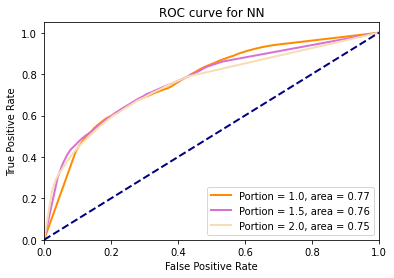

finish
finish
finish


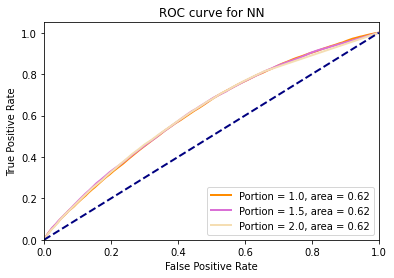

finish
finish
finish


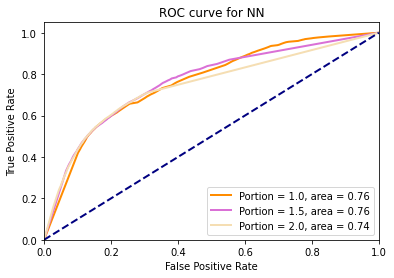

In [89]:
#for all data
ROC_curve_plot(model_predict_all_data, ans_all,test_index_list)

#for personal data
ROC_curve_plot(model_predict_personal, ans_all,test_index_list)

#for behavior data
ROC_curve_plot(model_predict_behaviorl, ans_all,test_index_list)

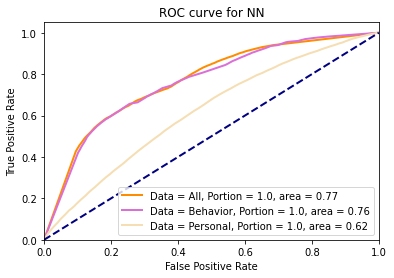

In [90]:
#畫出最終ROC curve比較

TPR_total_list = []
FPR_total_list = []
ROC_auc_list = []

#all_data 的 portion 1.0
train_datas = model_predict_all_data[0:5]
TPR, FPR = TPR_FPR(train_datas, ans_all, test_index_list)
TPR_total_list.append(TPR)
FPR_total_list.append(FPR)
ROC_auc_list.append(auc(FPR,TPR))

#behavior data的portion 1
train_datas = model_predict_behaviorl[0:5]
TPR, FPR = TPR_FPR(train_datas, ans_all, test_index_list)
TPR_total_list.append(TPR)
FPR_total_list.append(FPR)
ROC_auc_list.append(auc(FPR,TPR))

#personal data的portion 1
train_datas = model_predict_personal[0:5]
TPR, FPR = TPR_FPR(train_datas, ans_all, test_index_list)
TPR_total_list.append(TPR)
FPR_total_list.append(FPR)
ROC_auc_list.append(auc(FPR,TPR))


#ploting
fig = plt.figure()
lw = 2

Data = ['All', 'Behavior', 'Personal']
line_color = ['darkorange', 'orchid', 'wheat']
for i in range(3):
    plt.plot(FPR_total_list[i], TPR_total_list[i], color=line_color[i], lw=2, \
             label='Data = %s, Portion = %0.1f, area = %0.2f' % (Data[i],1,ROC_auc_list[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for NN')
plt.legend(loc="lower right")
plt.show()

In [110]:
Precision_Recall_all(model_predict_all_data, ans_all,test_index_list)

Presition rate = 0.24, Recall rate = 0.77, Acc rate = 0.61
Presition rate = 0.33, Recall rate = 0.60, Acc rate = 0.77
Presition rate = 0.38, Recall rate = 0.50, Acc rate = 0.81


In [111]:
Precision_Recall_all(model_predict_behaviorl, ans_all,test_index_list)

Presition rate = 0.26, Recall rate = 0.70, Acc rate = 0.68
Presition rate = 0.36, Recall rate = 0.55, Acc rate = 0.80
Presition rate = 0.39, Recall rate = 0.50, Acc rate = 0.82


In [112]:
Precision_Recall_all(model_predict_personal, ans_all,test_index_list)

Presition rate = 0.18, Recall rate = 0.64, Acc rate = 0.55
Presition rate = 0.23, Recall rate = 0.21, Acc rate = 0.79
Presition rate = 0.26, Recall rate = 0.06, Acc rate = 0.84
